In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import cg, LinearOperator, spilu
import time
import scipy.sparse.linalg as spla
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from utils import averageMeter
import pandas as pd

In [2]:
def compute_accuracy(output, target):
    # compute the accuracy of the prediction

    acc = ((output - target).abs() < 1e-3).float().mean()

    return acc

In [3]:
def train(data_loader, model, optimizer, epoch, criterion, device='cpu'):
    # set the model to training mode
    model.train()

    losses = averageMeter()
    accuracy = averageMeter()
    for (step, value) in enumerate(data_loader):

        data = value[0].to(device)
        target = value[1].to(device)

        optimizer.zero_grad()

        # forward the data to the model and get the output
        output = model(data)

        # compute accuracy
        acc = compute_accuracy(output, target)
        accuracy.update(acc.item(), data.size(0))

        # compute loss with the output and the target
        loss = criterion(output, target)

        # backward (PyTorch computes backpropagation for you)
        loss.backward()

        optimizer.step()

        # accumulate losses
        losses.update(loss.item(), data.size(0))

    print(f"[Epoch: {epoch}]\t lr: {optimizer.param_groups[0]['lr']:.4g}\t \
      loss_train: {losses.avg:.4f}\tacc_train: {accuracy.avg:.4f}")
    return losses.avg, accuracy.avg

In [4]:
@torch.no_grad()
def test(data_loader, model, criterion, device='cpu'):
    # set the model to evaluation mode
    model.eval()

    losses = averageMeter()
    accuracy = averageMeter()
    for (step, value) in enumerate(data_loader):

        data = value[0].to(device)
        target = value[1].to(device)

        # forward the data to the model and get the output
        output = model(data)

        # compute accuracy
        acc = compute_accuracy(output, target)
        accuracy.update(acc.item(), data.size(0))

        # compute loss with the output and the target
        loss = criterion(output, target)

        # accumulate losses
        losses.update(loss.item(), data.size(0))

    return losses.avg, accuracy.avg

In [5]:
class CNNPreconditioner(nn.Module):
    def __init__(self):
        super(CNNPreconditioner, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, 3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [6]:
def train_CNN(train_set, test_set, batch_size=64, lr=0.1, n_epoch=20, eval_epoch=5):

    # setup random seed
    torch.manual_seed(1337)
    torch.cuda.manual_seed(1337)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # setup model
    model = CNNPreconditioner()
    device = 'cpu'
    if torch.cuda.is_available():
        model = model.cuda()
        device = 'cuda'

    # setup data loader
    train_loader = DataLoader(
                    train_set,
                    batch_size=batch_size,
                    shuffle=True,
                    drop_last=True
                )

    test_loader = DataLoader(
                    test_set,
                    batch_size=128,
                    shuffle=False,
                    drop_last=False
                )

    # setup optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # setup loss function (criterion)
    criterion = nn.MSELoss()

    # training and evaluation
    losses_train = []
    accs_train = []
    losses_test = []
    accs_test = []
    for ep in range(n_epoch):

        # train an epoch and get the loss
        loss_train, acc_train = train(train_loader, model, optimizer, ep, criterion, device)
        losses_train.append(loss_train)
        accs_train.append(acc_train)

        if (ep + 1) % eval_epoch == 0:
            # evaluate current model and get the loss
            loss_test, acc_test = test(test_loader, model, criterion, device)
            losses_test.append(loss_test)
            accs_test.append(acc_test)
            print(f'[val]\tloss_test: {loss_test:.4f}\tacc_test: {acc_test:.4f}')

    # plot the training/testing loss and accuracy
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    ax[0].plot(np.arange(n_epoch), losses_train, color='b', label='train_loss')
    ax[0].plot(np.linspace(0, n_epoch, n_epoch//eval_epoch), losses_test, color='r', label='test_loss')
    ax[0].legend()

    ax[1].plot(np.arange(n_epoch), accs_train, color='b', label='train_acc')
    ax[1].plot(np.linspace(0, n_epoch, n_epoch//eval_epoch), accs_test, color='r', label='test_acc')
    ax[1].legend()

In [7]:
def generate_data(num_samples, n_values, equation_type='poisson'):
    matrices = []
    preconditioners = []
    for n in n_values:
        for _ in range(num_samples // len(n_values)):
            if equation_type == 'poisson':
                A, _ = poisson_equation(n)
            elif equation_type == 'heat':
                A, _ = heat_equation(n)
            elif equation_type == 'wave':
                A, _ = wave_equation(n)
            elif equation_type == 'ill_poisson':
                A, _ = ill_conditioned_poisson_equation(n)
                
            M_inv = np.linalg.inv(np.diag(np.diag(A)))
            
            # Normalize A and M_inv
            A = (A - A.min()) / (A.max() - A.min())
            M = (M_inv - M_inv.min()) / (M_inv.max() - M_inv.min())
            
            matrices.append(A)
            preconditioners.append(M_inv)
    return matrices, preconditioners

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, training_data):
        self.training_data = training_data
        self.data = training_data[0]

    # get sample
    def __getitem__(self, idx):
        A = self.data[idx]

        # convert to tensor
        n = A.shape[0]
        A_tensor = torch.tensor(A, dtype=torch.float32).reshape((1, n, n))

        target = self.training_data[1][idx]
        target = torch.tensor(target, dtype=torch.float32).reshape((1,n,n))

        return A_tensor, target

    def __len__(self):
        return len(self.data)

In [9]:
def cg_CNN(A, b, model, batch_size=1, tol=1e-10, max_iter=2000):
    n = A.shape[0]
    A_tensor = torch.tensor(A.reshape((batch_size, 1, n, n)), dtype=torch.float32)

    start_time = time.time()

    with torch.no_grad():
        M_inv_pred = model(A_tensor).squeeze().numpy()
        M_inv_pred = np.diag(np.diag(M_inv_pred))

    def preconditioner(x):
        return M_inv_pred @ x

    M = LinearOperator((n, n), matvec=preconditioner)

    x, info = cg(A, b, tol=tol, maxiter=max_iter, M=M)
    elapsed_time = time.time() - start_time

    return x, info, elapsed_time

In [10]:
def jacobi(A):
    M_inv = np.linalg.inv(np.diag(np.diag(A)))
    return M_inv

def gauss_seidel(A):
    L = np.tril(A)
    U = np.triu(A, 1)
    M_inv = np.linalg.inv(L + U)
    return M_inv

def incomplete_cholesky(A):
    A_sparse = csc_matrix(A)
    A_ilu = spilu(A_sparse)
    M_inv = np.linalg.inv(A_ilu.L.dot(A_ilu.L.T).toarray())
    return M_inv

In [11]:
# define conjugate gradient for classic preconditioner

def cg_classic(A, b, preconditioner_type, tol=1e-10, max_iter=2000):
    n = A.shape[0]
    
    start_time = time.time()
    M_inv = preconditioner_type(A)

    def preconditioner(x):
        return M_inv @ x

    M = LinearOperator((n, n), matvec=preconditioner)
    
    x, info = cg(A, b, tol=tol, maxiter=max_iter, M=M)
    elapsed_time = time.time() - start_time
    
    return x, info, elapsed_time

In [12]:
def results_test(n_values, num_samples, equation_type='poisson'):
    results = []
    for n in n_values:
        
        if equation_type == 'poisson':
                A_test, b_test = poisson_equation(n)
        elif equation_type == 'heat':
                A_test, b_test = heat_equation(n)
        elif equation_type == 'wave':
                A_test, b_test = heat_equation(n)
        elif equation_type == 'ill_poisson':
                A_test, b_test = ill_conditioned_poisson_equation(n)
        
         # exact solution
        x_exact = np.linalg.solve(A_test, b_test)

        # measure time and error for each preconditioner
        preconditioners_type = [jacobi, gauss_seidel, incomplete_cholesky]
        preconditioner_names = ["Jacobi", "Gauss-Seidel", "Incomplete Cholesky"]

        for preconditioner, name in zip(preconditioners_type, preconditioner_names):
            x, _, elapsed_time = cg_classic(A_test, b_test, preconditioner)
            error = np.linalg.norm(x - x_exact) / np.linalg.norm(x_exact)
            results.append((n, name, elapsed_time, error))
            print(f"n={n}, Preconditioner={name}, Computation Time={elapsed_time:.4f} seconds, Relative Error={error:.4e}")

        # GNN preconditioner
        x_cnn, _, cnn_time = cg_CNN(A_test, b_test, model)
        cnn_error = np.linalg.norm(x_cnn - x_exact) / np.linalg.norm(x_exact)
        results.append((n, "CNN", cnn_time, cnn_error))
        print(f"n={n}, Preconditioner=CNN, Computation Time={cnn_time:.4f} seconds, Relative Error={cnn_error:.4e}")

        # exact 
        start_time = time.time()
        x_exact = np.linalg.solve(A_test, b_test)
        exact_time = time.time() - start_time
        results.append((n, "Exact", exact_time, 0.0))
        print(f"n={n}, Preconditioner=Exact, Computation Time={exact_time:.4f} seconds, Relative Error=0.0000")

        print("---------------")
    return results

In [13]:
#Grid Size
global nnn 
nnn = 128

In [14]:
def poisson_equation(n, dx=0.01):
    h = dx
    main_diag = -2 * np.ones(n) / h**2
    off_diag = np.ones(n - 1) / h**2
    diagonals = [off_diag, main_diag, off_diag]
    offsets = [-1, 0, 1]
    A = diags(diagonals, offsets, shape=(n, n)).toarray()

    # assume f(x) = 1
    f = np.ones(n)
    b = f * (h ** 2)

    return A, b

[Epoch: 0]	 lr: 0.001	       loss_train: 0.0005	acc_train: 0.0083
[Epoch: 1]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.4070
[Epoch: 2]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.8794
[Epoch: 3]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9424
[Epoch: 4]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9520
[val]	loss_test: 0.0000	acc_test: 0.9523
[Epoch: 5]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9567
[Epoch: 6]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9613
[Epoch: 7]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9672
[Epoch: 8]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9673
[Epoch: 9]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9676
[val]	loss_test: 0.0000	acc_test: 0.9750
[Epoch: 10]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9751
[Epoch: 11]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9752
[Epoch: 12]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9754
[Epoch: 13]	 lr: 0.001	       loss_train: 0.0000	acc_trai

/Users/orenyang/.local/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


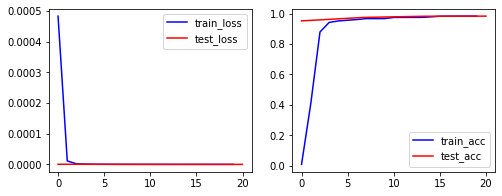

In [15]:
n_values_train = [nnn]
num_samples = 2000
training_data = generate_data(num_samples, n_values_train)

dataset = Dataset(training_data)

#split the dataset into two parts (train 85%, test 15%)
test_size = 0.15

test_amount= int(dataset.__len__() * test_size)

# this function will automatically randomly split your dataset but you could also implement the split yourself
train_set, test_set = random_split(dataset, [
            (dataset.__len__() - (test_amount)),
            test_amount
])
train_CNN(train_set, test_set)


A, b = poisson_equation(nnn)

x_exact = spla.spsolve(A, b)

model = CNNPreconditioner()

x, info, elapsed_time = cg_CNN(A, b, model)


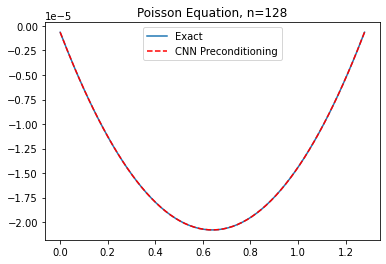

In [16]:
plt.plot(np.linspace(0,nnn*0.01,nnn),x_exact, label='Exact')
plt.plot(np.linspace(0,nnn*0.01,nnn),x,'r--',label = 'CNN Preconditioning')

plt.title('Poisson Equation, n={}'.format(nnn))
plt.legend()
plt.show()

In [17]:
# TEST 
n_values_test = [nnn]
results = results_test(n_values_test, num_samples=2000)

# dataframe the result 
df = pd.DataFrame(results, columns=["n", "Preconditioner", "Computation Time (s)", "Relative Error"])

n=128, Preconditioner=Jacobi, Computation Time=0.0084 seconds, Relative Error=3.1523e-15
n=128, Preconditioner=Gauss-Seidel, Computation Time=0.0020 seconds, Relative Error=1.4993e-14
n=128, Preconditioner=Incomplete Cholesky, Computation Time=0.0027 seconds, Relative Error=1.6580e-13
n=128, Preconditioner=CNN, Computation Time=0.0182 seconds, Relative Error=4.0131e-15
n=128, Preconditioner=Exact, Computation Time=0.0003 seconds, Relative Error=0.0000
---------------


In [18]:
def heat_equation(n, alpha=0.34, dt=0.01, dx=1.0):
    r = alpha * dt / (dx ** 2)
    main_diag = (1 - 2 * r) * np.ones(n)
    off_diag = r * np.ones(n - 1)
    diagonals = [off_diag, main_diag, off_diag]
    offsets = [-1, 0, 1]
    A = diags(diagonals, offsets, shape=(n, n)).toarray()
    b = np.ones(n) + 0.00001 * np.random.randn(n)  # with noise
    return A, b


[Epoch: 0]	 lr: 0.001	       loss_train: 0.0036	acc_train: 0.0716
[Epoch: 1]	 lr: 0.001	       loss_train: 0.0002	acc_train: 0.2695
[Epoch: 2]	 lr: 0.001	       loss_train: 0.0001	acc_train: 0.7572
[Epoch: 3]	 lr: 0.001	       loss_train: 0.0001	acc_train: 0.8799
[Epoch: 4]	 lr: 0.001	       loss_train: 0.0001	acc_train: 0.9032
[val]	loss_test: 0.0001	acc_test: 0.9094
[Epoch: 5]	 lr: 0.001	       loss_train: 0.0001	acc_train: 0.9094
[Epoch: 6]	 lr: 0.001	       loss_train: 0.0001	acc_train: 0.9105
[Epoch: 7]	 lr: 0.001	       loss_train: 0.0001	acc_train: 0.9236
[Epoch: 8]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9262
[Epoch: 9]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9314
[val]	loss_test: 0.0000	acc_test: 0.9313
[Epoch: 10]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9314
[Epoch: 11]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9315
[Epoch: 12]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9414
[Epoch: 13]	 lr: 0.001	       loss_train: 0.0000	acc_trai

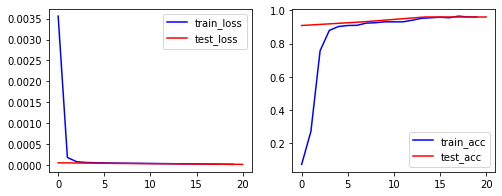

In [19]:
n_values_train = [nnn]
num_samples = 2000
training_data = generate_data(num_samples, n_values_train, equation_type='heat')

dataset = Dataset(training_data)

#split the dataset into two parts (train 85%, test 15%)
test_size = 0.15

test_amount= int(dataset.__len__() * test_size)

# this function will automatically randomly split your dataset but you could also implement the split yourself
train_set, test_set = random_split(dataset, [
            (dataset.__len__() - (test_amount)),
            test_amount
])
train_CNN(train_set, test_set)


A, b = heat_equation(nnn)

x_exact = spla.spsolve(A, b)

model = CNNPreconditioner()

x, info, elapsed_time = cg_CNN(A, b, model)


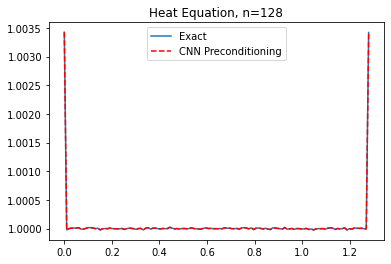

In [20]:
plt.plot(np.linspace(0,nnn*0.01,nnn),x_exact, label='Exact')
plt.plot(np.linspace(0,nnn*0.01,nnn),x,'r--',label = 'CNN Preconditioning')

plt.title('Heat Equation, n={}'.format(nnn))
plt.legend()
plt.show()

In [21]:
# TEST 
n_values_test = [nnn]
results = results_test(n_values_test, num_samples=2000,equation_type='heat')

# dataframe the result 
df = pd.DataFrame(results, columns=["n", "Preconditioner", "Computation Time (s)", "Relative Error"])

n=128, Preconditioner=Jacobi, Computation Time=0.0052 seconds, Relative Error=1.7026e-11
n=128, Preconditioner=Gauss-Seidel, Computation Time=0.0018 seconds, Relative Error=1.5792e-16
n=128, Preconditioner=Incomplete Cholesky, Computation Time=0.0024 seconds, Relative Error=6.8167e-11
n=128, Preconditioner=CNN, Computation Time=0.0115 seconds, Relative Error=6.8874e-11
n=128, Preconditioner=Exact, Computation Time=0.0006 seconds, Relative Error=0.0000
---------------


In [22]:
def wave_equation(n, c=1.0, dt=0.01, dx=1):
    r = (c * dt / dx) ** 2
    main_diag = (2 - 2 * r) * np.ones(n)
    off_diag = r * np.ones(n-1)
    diagonals = [off_diag, main_diag, off_diag]
    offsets = [-1, 0, 1]
    A = diags(diagonals, offsets, shape=(n, n)).toarray()
    b = np.ones(n) + 0.00001 * np.random.randn(n)  # with noise
    return A, b

[Epoch: 0]	 lr: 0.001	       loss_train: 0.0007	acc_train: 0.0730
[Epoch: 1]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.4394
[Epoch: 2]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.8412
[Epoch: 3]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9085
[Epoch: 4]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9305
[val]	loss_test: 0.0000	acc_test: 0.9387
[Epoch: 5]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9429
[Epoch: 6]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9523
[Epoch: 7]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9686
[Epoch: 8]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9823
[Epoch: 9]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9812
[val]	loss_test: 0.0000	acc_test: 0.9827
[Epoch: 10]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9827
[Epoch: 11]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9827
[Epoch: 12]	 lr: 0.001	       loss_train: 0.0000	acc_train: 0.9827
[Epoch: 13]	 lr: 0.001	       loss_train: 0.0000	acc_trai

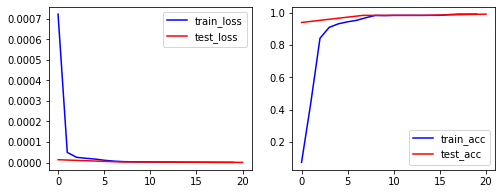

In [23]:
n_values_train = [nnn]
num_samples = 2000
training_data = generate_data(num_samples, n_values_train, equation_type='wave')

dataset = Dataset(training_data)

#split the dataset into two parts (train 85%, test 15%)
test_size = 0.15

test_amount= int(dataset.__len__() * test_size)

# this function will automatically randomly split your dataset but you could also implement the split yourself
train_set, test_set = random_split(dataset, [
            (dataset.__len__() - (test_amount)),
            test_amount
])
train_CNN(train_set, test_set)


A, b = wave_equation(nnn)

x_exact = spla.spsolve(A, b)

model = CNNPreconditioner()

x, info, elapsed_time = cg_CNN(A, b, model)


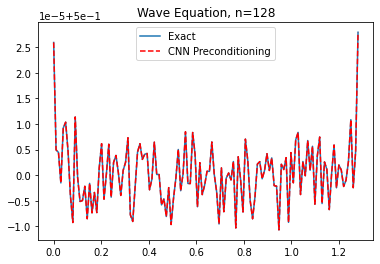

In [24]:
plt.plot(np.linspace(0,nnn*0.01,nnn),x_exact, label='Exact')
plt.plot(np.linspace(0,nnn*0.01,nnn),x,'r--',label = 'CNN Preconditioning')

plt.title('Wave Equation, n={}'.format(nnn))
plt.legend()
plt.show()

In [25]:
# TEST 
n_values_test = [nnn]
results = results_test(n_values_test, num_samples=2000, equation_type='wave')

# dataframe the result 
df = pd.DataFrame(results, columns=["n", "Preconditioner", "Computation Time (s)", "Relative Error"])

n=128, Preconditioner=Jacobi, Computation Time=0.0033 seconds, Relative Error=1.7026e-11
n=128, Preconditioner=Gauss-Seidel, Computation Time=0.0028 seconds, Relative Error=1.5669e-16
n=128, Preconditioner=Incomplete Cholesky, Computation Time=0.0034 seconds, Relative Error=2.0396e-11
n=128, Preconditioner=CNN, Computation Time=0.0123 seconds, Relative Error=8.6743e-11
n=128, Preconditioner=Exact, Computation Time=0.0021 seconds, Relative Error=0.0000
---------------
